In [66]:
#load packages for notebook
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
#define global variabels
period="max"
interval="1mo"
pricetype="Close"
start_date = "2024-01-01"
end_date = "2024-12-31"
title="Portfolio and Indices Evolution 2024"

#define yahoo tickers for base data for investment controlling
tickers = ['SPY','IEV','EWJ','EWL','EEM','GLD']

#define strategic weights for investment strategies
weights = {
    "SPY": 0.3,
    "IEV": 0.2,
    "EWJ": 0.3,
    "EWL": 0.05,
    "EEM": 0.1,
    "GLD": 0.05
}

In [ ]:
#get the price data
#for this notebook we use the max data possible, a MoM price frequency and use the closing price
def load_monthly_data(tickers, period=period, interval=interval,pricetype=pricetype):
    
    all_data = {}

    for ticker in tickers:
        etf = yf.Ticker(ticker)
        hist = etf.history(period=period, interval=interval)
        all_data[ticker] = hist[pricetype] 

    df = pd.DataFrame(all_data)
    df = df.dropna()

    return df

In [71]:
def generate_column_mapping(df_columns, weights_keys):
    mapping = {}
    for col in df_columns:
        # find a weight key that is contained in the column name (case-insensitive)
        for key in weights_keys:
            if key.lower() in col.lower():
                mapping[col] = key
                break
    return mapping

In [72]:
#data transformation for investment controlling dashboard
def compute_returns(pricedata, tickers):

    for ticker in tickers:
        ret_col = f"ret_{ticker.lower()}"
        index_col = f"index_{ticker.lower()}"
        
        pricedata[ret_col] = pricedata[ticker].pct_change()

        pricedata.loc[pricedata.index[0], ret_col] = 0

    return pricedata

In [73]:
def compute_plot(pricedata, tickers, weights, start_date=None, end_date=None, title="Portfolio and Indices"):
    
    # Slice data based on start_date and end_date
    data = pricedata.copy()
    if start_date and end_date:
        data = data.loc[start_date:end_date]
    elif start_date:
        data = data.loc[start_date:]
    elif end_date:
        data = data.loc[:end_date]
    
    # Compute indices normalized to 1 at first row
    index_cols = {}
    for ticker in tickers:
        ret_col = f"ret_{ticker.lower()}"
        index_col = f"index_{ticker.lower()}"
        index_cols[index_col] = (1 + data[ret_col]).cumprod()
        index_cols[index_col] /= index_cols[index_col].iloc[0]  # normalize
    
    data_indices = pd.DataFrame(index_cols, index=data.index)
    
    # Compute portfolio index
    weights_lower = {k.lower(): v for k, v in weights.items()}
    data_indices["index_portfolio"] = sum(
        data_indices[f"index_{ticker}"] * weight for ticker, weight in weights_lower.items()
    )
    
    # Plotting
    plt.figure(figsize=(12,6))
    for col in data_indices.columns:
        if col == "index_portfolio":
            plt.plot(data_indices.index, data_indices[col], label="PORTFOLIO", linewidth=2.5, color='black')
        else:
            plt.plot(data_indices.index, data_indices[col], label=col.replace("index_", "").upper(), alpha=0.7)
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Normalized Index")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return data_indices

In [74]:
#price data gets loaded according to tickers
pricedata = load_monthly_data(tickers)

In [75]:
pricedata_transformed = compute_returns(pricedata, tickers)

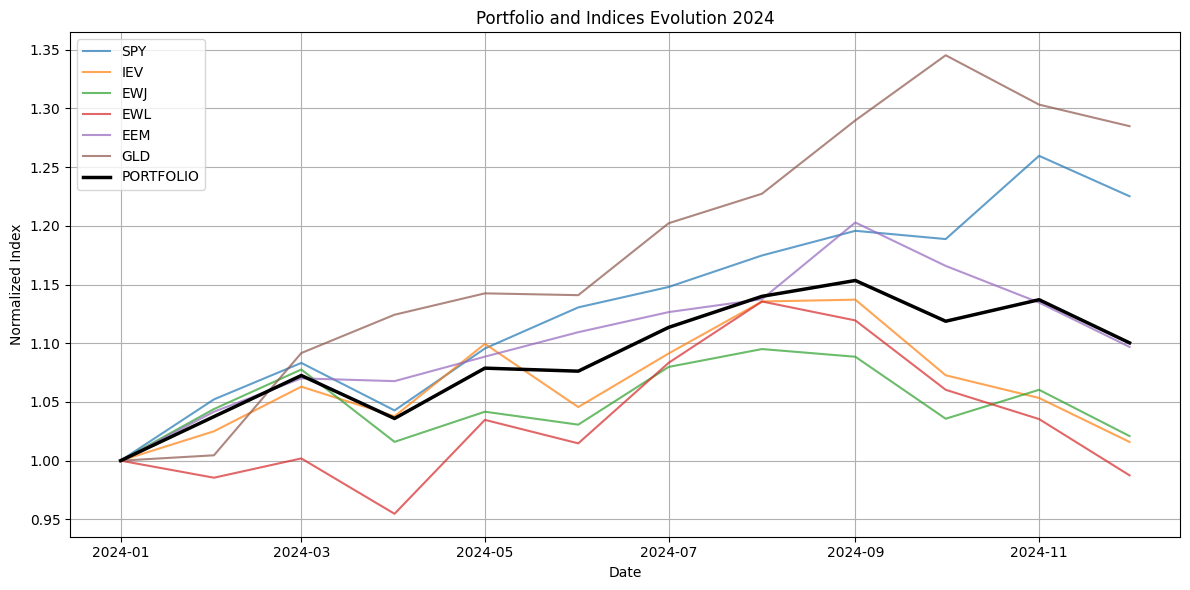

In [76]:
indices_2024 = compute_plot(pricedata, tickers, weights, start_date, end_date,
                                        title=title)

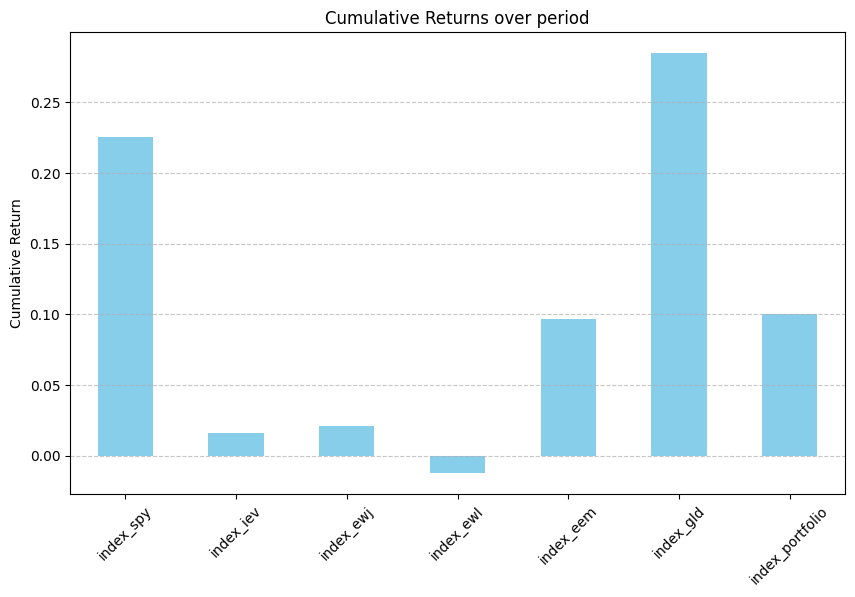

In [77]:
# Take the last row
last_row = indices_2024.iloc[-1]

# Compute cumulative returns relative to 1
cum_returns = last_row - 1

# Plot bar chart
plt.figure(figsize=(10,6))
cum_returns.plot(kind='bar', color='skyblue')
plt.ylabel('Cumulative Return')
plt.title('Cumulative Returns over period')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

{'index_spy': 'SPY', 'index_iev': 'IEV', 'index_ewj': 'EWJ', 'index_ewl': 'EWL', 'index_eem': 'EEM', 'index_gld': 'GLD'}


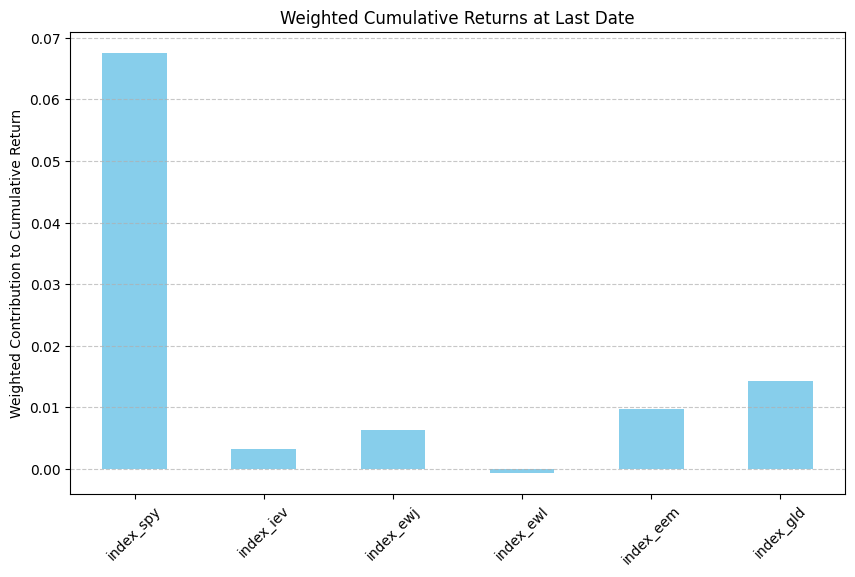

In [78]:
# usage
column_mapping = generate_column_mapping(indices_2024.columns, weights.keys())
print(column_mapping)

# Compute weighted cumulative return
weighted_cum_return = sum((last_row[col] - 1) * weights[column_mapping[col]] for col in column_mapping)

# Compute weighted contributions per index for plotting
weighted_contributions = {col: (last_row[col]-1) * weights[column_mapping[col]] for col in column_mapping}

# Plot
plt.figure(figsize=(10,6))
pd.Series(weighted_contributions).plot(kind='bar', color='skyblue')
plt.ylabel('Weighted Contribution to Cumulative Return')
plt.title('Weighted Cumulative Returns at Last Date')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()